# Imports

In [1]:
%matplotlib inline

import time
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import imageio
from io import BytesIO

# Global variables

In [2]:
WIDTH = 120
HEIGHT = 120
OS = "windows"
valid_size = 0.2
# label_name = ["palm_horizontal", "L", "fist_horizontal", "fist_vertical", "thumb_up", "index", "ok", "palm_vertical", "C", "thumb_down"]

# Loading data

In [3]:
def load_labelling_data(width, height, oper_sys):
    X = []
    y = []
    if oper_sys == "windows":
        split_ = "\\"
    else:
        split_ = "/"
    for root, _, files in tqdm(os.walk("../", topdown=False)): 
        for name in files:
            path = os.path.join(root, name)
            if path.endswith("jpg"):
                # if path.split(split_)[-1][0] != ".":
                if path.split(split_)[-1][0].isalpha():
                    # Loading images
                    img = cv2.imread(path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    img = cv2.resize(img, (width, height))
                    X.append(img)
                    # Loading labels
                    category = path.split(split_)[-1].split("_")[0]
                    # label = int(category.split("_")[0]) - 1
                    y.append(category)
    X = np.array(X)
    y = np.array(y)
    return X.reshape(X.shape[0], height, width, 1), y

def load_test_data(width, height, oper_sys):
    X = []
    if oper_sys == "windows":
        split_ = "\\"
    else:
        split_ = "/"
    for root, _, files in tqdm(os.walk("../", topdown=False)): 
        for name in files:
            path = os.path.join(root, name)
            if path.endswith("jpg"):
                # if path.split(split_)[-1][0] != ".":
                if not path.split(split_)[-1][0].isalpha() and path.split(split_)[-1][0] != ".":
                    # Loading images
                    img = cv2.imread(path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    img = cv2.resize(img, (width, height))
                    X.append(img)
    X = np.array(X)
    return X.reshape(X.shape[0], height, width, 1)

def load_dataset_data(width, height, oper_sys):
    X = []
    y = []
    stop = False
    if oper_sys == "windows":
        split_ = "\\"
    else:
        split_ = "/"
    for root, dirs, files in tqdm(os.walk(".", topdown=False)): 
        for name in files:
            path = os.path.join(root, name)
            if path.endswith("png"):
                # Loading labels
                category = path.split(split_)[4]
                label = int(category.split("_")[0]) - 1
                y.append(label)
                # Loading images
                img = cv2.imread(path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (width, height))
                X.append(img)
    X = np.array(X)
    y = np.array(y)
    return X.reshape(X.shape[0], height, width, 1), y

# def get_background_images():
# 	images = []
# 	with open('data_background/test.mkv', 'rb') as file: # kaggle : ../input/hand-gesture/data_background/test.mkv
# 		content = file.read()
# 		print(file)
# 	vid = imageio.get_reader(BytesIO(content),  'ffmpeg')
# 	images = []
# 	for num, image in enumerate(vid.iter_data()): 
# 		if num % 14 == 0:
# 			img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)[:,:,np.newaxis]
# 			images.append(img)
# 	return np.array(images)

def get_background_images():
	images = []
	vidcap = cv2.VideoCapture('data_background/test.mkv')
	success,image = vidcap.read()
	while success:
		img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)[:,:,np.newaxis]
		images.append(img)
		success, image = vidcap.read()
	return np.array(images)

In [4]:
X_labelling, y_labelling = load_labelling_data(WIDTH, HEIGHT, OS)
background_images = get_background_images()[::10]

128it [00:00, 761.89it/s]


In [5]:
print(X_labelling.shape)
print(y_labelling.shape)
print(background_images.shape)

(99, 120, 120, 1)
(99,)
(145, 720, 960, 1)


# Data augmentation

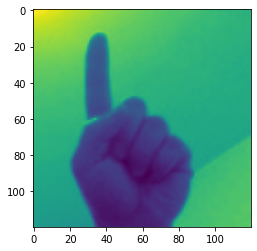

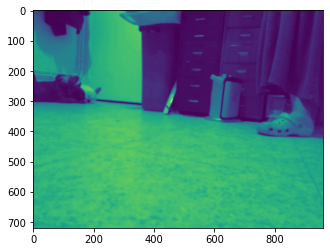

In [6]:
plt.imshow(X_labelling[0])
plt.show()
plt.imshow(background_images[0])
plt.show()

In [7]:
def add_background_to_data(background_images, hand_images, labels):
    final_images = []
    new_labels = []
    for idx, hand_img in enumerate(tqdm(hand_images)):
        for background_img in background_images:
            for r in range(1, 4):
                resize = int(hand_img.shape[0]*r)
                hand_img_resized = cv2.resize(hand_img, (resize, resize))[:,:,np.newaxis]
                y_offset = np.random.randint(background_img.shape[0] - hand_img_resized.shape[0])
                x_offset = np.random.randint(background_img.shape[1] - hand_img_resized.shape[1])
                tmp = background_img.copy()
                tmp[y_offset:y_offset+hand_img_resized.shape[0], x_offset:x_offset+hand_img_resized.shape[1]] = hand_img_resized
                tmp = cv2.resize(tmp, (128, 128))[:,:,np.newaxis]
                final_images.append(tmp)
                new_labels.append(labels[idx])
    return np.array(final_images), np.array(new_labels)

In [8]:
X, y = add_background_to_data(background_images, X_labelling, y_labelling)
print(X.shape)
print(y.shape)

100%|██████████| 99/99 [00:06<00:00, 16.45it/s]


(43065, 128, 128, 1)
(43065,)


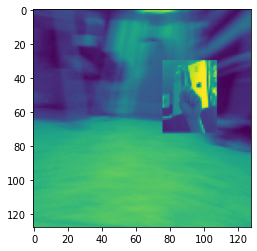

In [9]:
plt.imshow(X[1000])

In [10]:
label_names, y = np.unique(y, return_inverse=True) ## Converts to categorical int
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=valid_size, random_state=42)

In [11]:
X_train.shape

(34452, 128, 128, 1)

# Building model

In [12]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(X_train[0].shape))) 
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu')) 
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Dropout(rate=0.2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(len(label_name), activation='softmax'))
    return model

# Training model

In [13]:
train_ = False

if train_ :
    model = build_model()
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=50, batch_size=128, verbose=5, validation_data=(X_valid, y_valid))
    model.save('tmp_model.h5')
else:
    model = tf.keras.models.load_model("best_model.h5", custom_objects=None, compile=True, options=None)

model.summary()
valid_loss, valid_acc = model.evaluate(X_valid, y_valid)
print('Valid accuracy: {:2.2f}%'.format(valid_acc*100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

# Inference

In [14]:
if train_:
	# summarize history for accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title('model accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'valid'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title('model loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'valid'], loc='upper left')
	plt.show()

In [15]:
X_test = load_test_data(128, 128, OS)

128it [00:00, 197.52it/s]


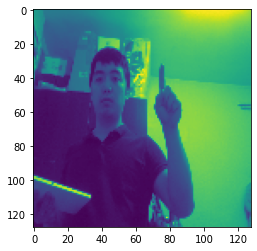

In [16]:
plt.imshow(X_test[0])

In [17]:
preds = np.argmax(model.predict(X_test), axis=1)
label_names

array(['FINGER', 'FIST', 'LEFT', 'PALM', 'RIGHT'], dtype='<U6')

In [18]:
# for i in range(len(preds)):
#     print("=======================================")
#     plt.imshow(X_test[i])
#     plt.show()
#     print(label_names[preds[i]])

In [19]:
inference_ = True

if inference_ :
	cv2.destroyAllWindows()
	before = time.time()
	vid = cv2.VideoCapture(0)
	while True:

		ret, frame = vid.read()
		cv2.imshow('frame', frame)
		if cv2.waitKey(1) & 0xFF == ord('q'):
			break
		img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
		img = cv2.resize(img, (128, 128))
		img = img.reshape(1, 128, 128, 1)

		after = int(time.time() - before)
		print(label_names[np.argmax(model.predict(img))])

	vid.release()
	cv2.destroyAllWindows()


KeyboardInterrupt

